# Joern-ey into Progol

We have [generated](./generate_minimal_ilp_dataset.ipynb) a subset of the Juliet dataset consisting of small buffer overflow examples, and have [transformed](./Joern-ey%20into%20ILP.ipynb) each piece of source code into a a set of Prolog facts. In this notebook we generate Progol scripts from this dataset, and try to get it to learn rules to determine when a buffer overflow occurs.

## Generating Progol
In this section we load in the ILP dataset and its Progol representations, manually find the "error" node in each example, then define the `make_progol_script` function which will generate a script from the given testcase id's.

In [1]:
import pandas as pd

In [2]:
import tempfile
import subprocess
import graph_visualisation

In [3]:
ilp_data = pd.read_csv("../data/ilp_dataset.csv.gz")
ilp_data = ilp_data.drop("Unnamed: 0", axis=1)
ilp_data.head()

,testcase_ID,filename,code,flaw,flaw_loc,bug,code_length
0,62804,000/062/804/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,1722
1,62821,000/062/821/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,35,False,1808
2,62852,000/062/852/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,30,False,1674
3,62853,000/062/853/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,2396
4,62854,000/062/854/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,2414


In [4]:
prolog = pd.read_csv("../data/ilp_prolog_data.csv.gz")
prolog = prolog.drop("Unnamed: 0", axis=1)
prolog.head()

,testcase_ID,flaw,bug,code_length,tree,source_map
0,-232086,CWE-122,True,1625,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_232086_id_1_f_l_c_, ""p..."
1,-232012,CWE-122,True,1619,% START: Generated Prolog\n% NODE PROPERTIES \...,% CODE\nsource_code(bad_232012_id_1_f_l_48_c_1...
2,-62917,CWE-121,True,1622,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62917_id_0_f_l_c_, ""p1..."
3,-62916,CWE-121,True,1649,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62916_id_0_f_l_c_, ""p1..."
4,-62915,CWE-121,True,1638,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62915_id_0_f_l_c_, ""p2..."


In [5]:
juliet = pd.read_csv("../data/buffer_overflow_data.csv.gz")
juliet.drop("Unnamed: 0", axis=1)
juliet.head()

,Unnamed: 0,Unnamed: 0.1,testcase_ID,filename,code,flaw,flaw_loc,bug
0,984,984,62516,000/062/516/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,112,False
1,985,985,62517,000/062/517/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,117,False
2,986,986,62518,000/062/518/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,117,False
3,987,987,62519,000/062/519/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,123,False
4,988,988,62520,000/062/520/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,123,False


In [6]:
prolog['source_code'] = ''
prolog['flaw_loc'] = 0
prolog['bad_code'] = ''

In [7]:
for i in range(len(prolog)):
    label = prolog.iloc[i].testcase_ID == juliet.testcase_ID
    prolog['source_code'].iloc[i] = juliet.loc[label].iloc[0].code
    prolog['flaw_loc'].iloc[i] = juliet.loc[label].iloc[0].flaw_loc
    

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
for i in range(len(prolog)):
    loc =  prolog.iloc[i].flaw_loc
    testcase_ID = prolog.iloc[i].testcase_ID
    if testcase_ID < 0:
        prolog['bad_code'].iloc[i] = prolog.iloc[i].source_code.split('\n')[loc-1].strip()[0:-1]
    else:
        prolog['bad_code'].iloc[i] = prolog.loc[prolog.testcase_ID == -testcase_ID].iloc[0].bad_code

In [9]:
prolog.head()

,testcase_ID,flaw,bug,code_length,tree,source_map,source_code,flaw_loc,bad_code
0,-232086,CWE-122,True,1625,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_232086_id_1_f_l_c_, ""p...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,31,"memmove(data, source, 10*sizeof(int))"
1,-232012,CWE-122,True,1619,% START: Generated Prolog\n% NODE PROPERTIES \...,% CODE\nsource_code(bad_232012_id_1_f_l_48_c_1...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,31,"memcpy(data, source, 10*sizeof(int))"
2,-62917,CWE-121,True,1622,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62917_id_0_f_l_c_, ""p1...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,32,"memmove(data, source, 10*sizeof(int))"
3,-62916,CWE-121,True,1649,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62916_id_0_f_l_c_, ""p1...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,34,"memmove(data, source, 10*sizeof(int))"
4,-62915,CWE-121,True,1638,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62915_id_0_f_l_c_, ""p2...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,34,"memmove(data, source, 10*sizeof(int))"


In [10]:
good_examples = prolog[prolog['bug'] == False]
bad_examples = prolog[prolog['bug'] == True]

In [11]:
good_examples.head()

,testcase_ID,flaw,bug,code_length,tree,source_map,source_code,flaw_loc,bad_code
20,62804,CWE-121,False,1722,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(good_62804_id_0_f_l_c_, ""p...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,33,data[i] = source[i]
21,62821,CWE-121,False,1808,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(good_62821_id_0_f_l_c_, ""R...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,35,data[i] = source[i]
22,62852,CWE-121,False,1674,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(good_62852_id_0_f_l_c_, ""p...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,30,"memcpy(data, source, 10*sizeof(int))"
23,62853,CWE-121,False,2396,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(good_62853_id_0_f_l_c_, ""d...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,33,"memcpy(data, source, 10*sizeof(int))"
24,62854,CWE-121,False,2414,% START: Generated Prolog\n% NODE PROPERTIES \...,% CODE\nsource_code(good_62854_id_0_f_memcpy_0...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,33,"memcpy(data, source, 10*sizeof(int))"


In [12]:
def extract_node_ids(tree):
    nodes = set()
    
    in_ast_section = False
    
    for line in tree.split('\n'):
        line = line.strip()
        
        if line == '% AST':
            in_ast_section = True
        
        if line == '% CFG':
            in_ast_section = False
            
        if line == '% REF':
            in_ast_section = False
        
        if in_ast_section and not line.startswith("%"):
            parent, child = line[4:-2].split(", ")
            nodes.add(parent)
            nodes.add(child)
            
    return nodes

In [13]:
# good nodes_g
nodes_g = set()

for i in range(len(good_examples)):
    good_nodes = extract_node_ids(good_examples.iloc[i].tree)
    nodes_g = set.union(nodes_g,good_nodes)

    
# bad nodes_b
nodes_b = set()

for i in range(len(bad_examples)):
    bad_nodes = extract_node_ids(bad_examples.iloc[i].tree)
    nodes_b = set.union(nodes_b,bad_nodes)

nodes = set.union(nodes_g,nodes_b)


Manually find the "error" node for each testcase, and tag those as the positive or  negative examples.

In [14]:
print(bad_examples.source_map.iloc[0])

% CODE
source_code(bad_232086_id_1_f_l_c_, "p1").
source_code(bad_232086_id_2_f_l_c_, "p1").
source_code(bad_232086_id_3_f_l_c_, "p1").
source_code(bad_232086_id_4_f_l_c_, "p2").
source_code(bad_232086_id_5_f_l_c_, "p2").
source_code(bad_232086_id_6_f_l_c_, "p1").
source_code(bad_232086_id_7_f_l_c_, "p1").
source_code(bad_232086_id_8_f_l_c_, "p1").
source_code(bad_232086_id_9_f_l_c_, "p2").
source_code(bad_232086_id_10_f_l_48_c_9_, "int argc").
source_code(bad_232086_id_11_f_l_c_, "p1").
source_code(bad_232086_id_12_f_l_48_c_19_, "char * argv[]").
source_code(bad_232086_id_13_f_l_c_, "p1").
source_code(bad_232086_id_14_f_l_c_, "p1").
source_code(bad_232086_id_15_f_l_c_, "p1").
source_code(bad_232086_id_16_f_l_c_, "p1").
source_code(bad_232086_id_17_f_l_c_, "p1").
source_code(bad_232086_id_18_f_l_c_, "p3").
source_code(bad_232086_id_19_f_l_c_, "p1").
source_code(bad_232086_id_20_f_l_c_, "p2").
source_code(bad_232086_id_21_f_l_c_, "p1").
source_code(bad_232086_id_22_f_l_c_, "p2").
source

In [15]:
def find_bug_id(good_examples, i = 0):
    
    tree = good_examples.source_map.iloc[i]
    parents = []
    children = []
    in_code_section = False
    temp = 0
    for line in tree.split('\n'):
        line = line.strip()
        
        if line == '% CODE':
            in_code_section = True
        
        if in_code_section and not line.startswith("%"):
            try:
                #import pdb; pdb.set_trace()
                parent, child = line[12:-3].split(', "')
                parents.append(parent)
                children.append(child)
            except:
                temp +=1
    zipbObj = zip(children, parents)
    bug_node = dict(zipbObj)
    
    loc = good_examples.iloc[i].flaw_loc
    source_code = good_examples.iloc[i].bad_code

    return bug_node[source_code]

In [16]:
find_bug_id(bad_examples,1)

'bad_232012_id_146_f_memcpy_01_c_l_30_c_8_'

In [17]:
bad_node = []
good_node = []
for i in range(20):
    bad_node.append(find_bug_id(bad_examples,i))
    good_node.append(find_bug_id(good_examples,i))

In [18]:
types = [
    'node('+node_id+').' for node_id in nodes
]

positive_examples = [
    'bug('+node_id+').' for node_id in bad_node
]

negative_examples = [
    ':- bug('+node_id+').' for node_id in good_node
]

In [51]:
def make_progol_script(header, testcases, types=types, positive_examples=positive_examples, negative_examples=negative_examples):
    script_template = """
{header}

%% Types
{types}

%% background knowledge
{bg_knowledge}

%% learning task
%% positive examples
{positive_examples}

%% negative examples
{negative_examples}

    """

    script = script_template.format(
        header = header,
        types = '\n'.join(types),
        bg_knowledge = '\n'.join(prolog['tree']),
        positive_examples='\n'.join(positive_examples),
        negative_examples='\n'.join(negative_examples),
    )
    
    # remove all lines not related to this testcase
    script = '\n'.join([
        line for line in script.split("\n")  if any(
            str(testcase) in line for testcase in testcases
        ) or not ("good_" in line or "bad_" in line)
    ])
    
    return script

## Experimentation
In this section we try different subsets of the dataset with different Progol settings. 

We try by setting the following header:

In [20]:
header = """
% Settings
:- set(c,30)?
:- set(i,30)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?
"""

script = make_progol_script(header, {62804, 62852, 62869, 232012, 62900})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232012_id_146_f_memcpy_01_c_l_30_c_8_).]
[Generalising <bug(bad_232012_id_146_f_memcpy_01_c_l_30_c_8_).>]
bug(A) :- ast(A,B), ast(A,C)

This creates one rule per example, but is unable to create a general one. These rules succinctly describe the situation, and three of the examples have the same rule!

```
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), assignment(A), ast(B,C), compMemberAccess(B), ref(C,D).
```

We try the same setup, but only for those buffer overflows which happen due to a `memcpy`:

In [21]:
script = make_progol_script(header, {
    62852,
    62853,
    62854,
    62869,
    232012,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232012_id_146_f_memcpy_01_c_l_30_c_8_).]
[Generalising <bug(bad_232012_id_146_f_memcpy_01_c_l_30_c_8_).>]
bug(A) :- ast(A,B), ast(A,C)

It produces 5 of the exact same "most specific clauses", but is still unable to give a final output?
```
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
```

**Question:** Why is it unable to combine them?

Finally, try for all the examples:

In [22]:
script = make_progol_script(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_145_f_memmove_01_c_l_30_c_8_).]
[Generalising <bug(bad_232086_id_145_f_memmove_01_c_l_30_c_8_).>]
bug(A) :- ast(A,B), ast(A,

It produces two different rules (grouped below by rule not output or testcase):

```
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), assignment(A), ast(B,C), compMemberAccess(B), ref(C,D).
```

The first rule is generated for all buffer overflows which make use of a bulk memory operation (e.g. `memcpy` and `memmove`) whilst the second rule is for the examples where an array is copied item by item. 

What do these rules mean? Let's visualise them to find out:

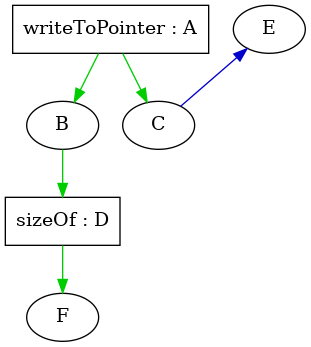

In [23]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C,E), ast(D,F), sizeOf(D)."
))

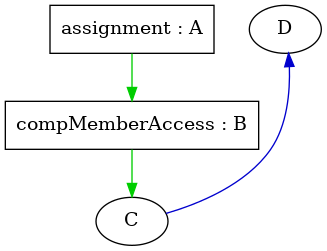

In [24]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- ast(A,B), assignment(A), ast(B,C), compMemberAccess(B), ref(C,D)."
))

**Question:** Can ILP learn logical or's? And so could these three rules be considered in composite?

**Question:** Can we create probabilistic model from these rules?

In [25]:
script = make_progol_script("""
% Settings
:- set(c,40)?
:- set(i,40)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,200)?
:- set(noise,0.2)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, cfg(+node,-node))?
:- modeb(*, cfg(-node,+node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))? """, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,40)? - Time taken 0.00s]
[:- set(i,40)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,200)? - Time taken 0.00s]
[:- set(noise,0.200)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,cfg(+node,-node))? - Time taken 0.00s]
[:- modeb(100,cfg(-node,+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[General

bug(A) :- ast(A,B), ast(A,C), ast(A,D), cfg(A,E), cfg(B,A), writeToPointer(A), ast(B,F), ast(B,G), cfg(C,G), cfg(D,C), cfg(E,H), cfg(F,B), cfg(I,D), ref(C,J), ref(D,K), ref(E,K), ast(F,L), ast(I,M), cfg(G,L), cfg(H,N), cfg(L,F), cfg(M,I), ref(M,J), ref(O,K), ref(P,K), assignment(I), sizeOf(F), ast(N,E), ast(N,H), cfg(N,Q), cfg(O,R), cfg(P,S), cfg(T,M), cfg(U,P), cfg(V,O), compMemberAccess(N), ast(Q,N), ast(T,O), ast(T,W), ast(U,X), ast(U,Y), cfg(S,Z), cfg(Q,Y), cfg(R,A0), cfg(W,T), cfg(Z,V), ref(B0,U), assignment(T), ast(W,A0), ast(W,C0), ast(X,K), ast(X,T), ast(X,V), ast(X,Z), ast(X,D0), ast(X,E0), ast(A0,R), ast(Z,P), ast(Z,S), cfg(A0,W), assignment(Z), alloc(A0), ast(D0,A), ast(D0,I), ast(D0,J), ast(D0,Q).
[Most-specific clause reduced by 2 literals]
[Most specific clause is]

bug(A) :- ast(A,B), ast(A,C), ast(A,D), cfg(A,E), cfg(B,A), writeToPointer(A),
	ast(B,F), ast(B,G), cfg(C,G), cfg(D,C), cfg(E,H), cfg(F,
	B), cfg(I,D), ref(C,J), ref(D,K), ref(E,K), ast(F,L),
	ast(I,M), cfg(G,

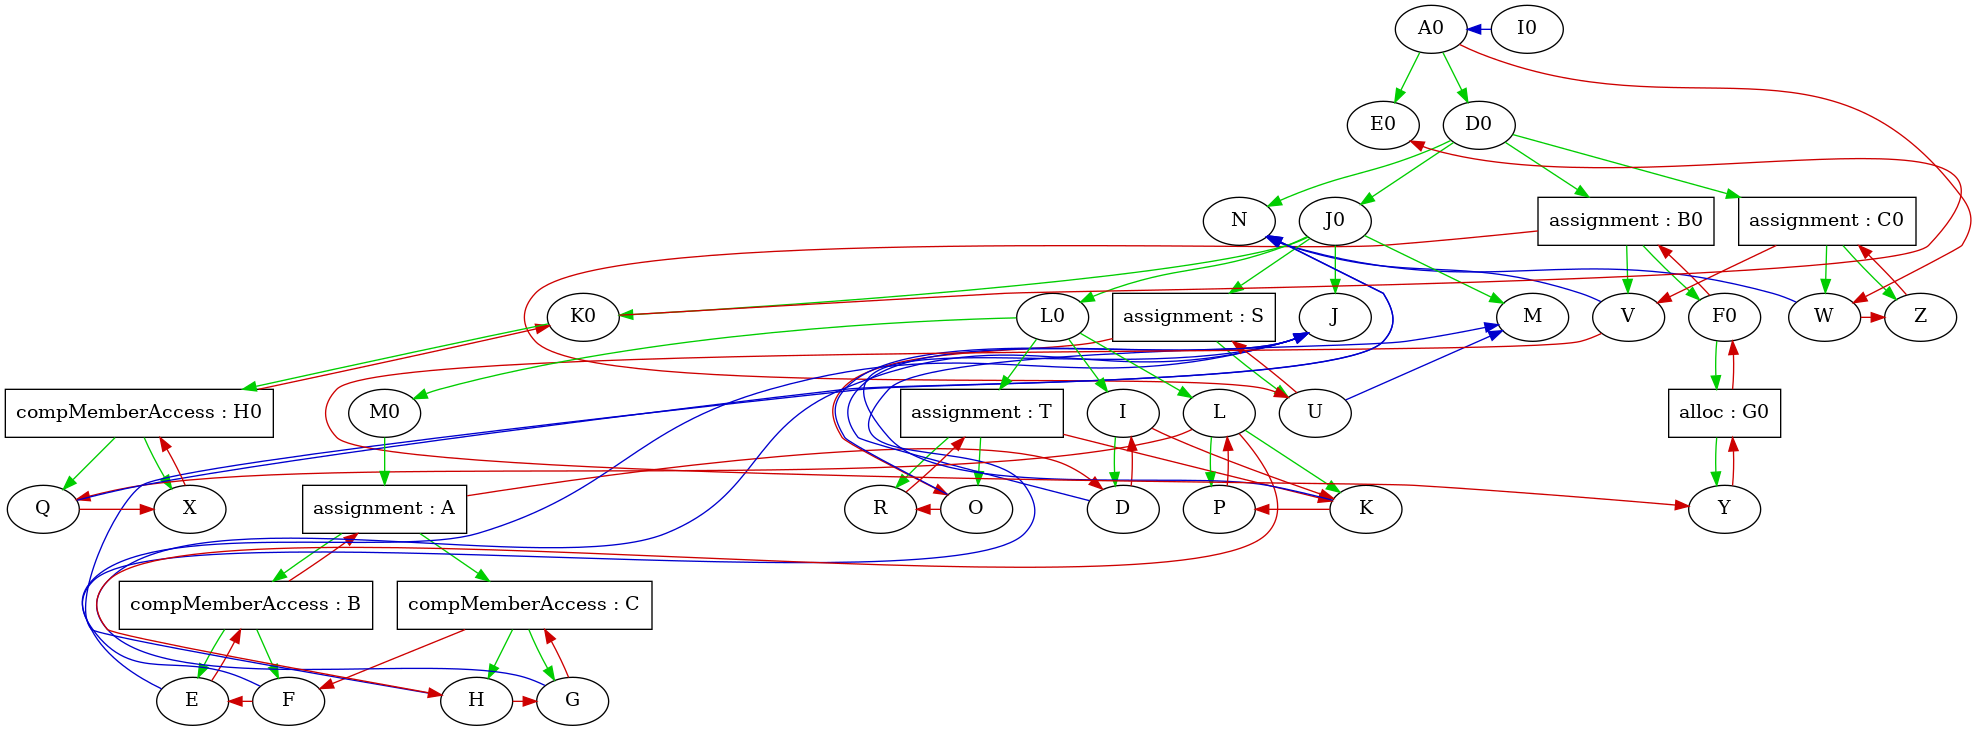

In [26]:
rule = "bug(A) :- ast(A,B), ast(A,C), cfg(A,D), cfg(B,A), assignment(A), ast(B,E), ast(B,F), ast(C,G), ast(C,H), cfg(C,F), cfg(D,I), cfg(E,B), cfg(G,C), ref(D,J), compMemberAccess(B), compMemberAccess(C), ast(I,D), cfg(F,E), cfg(H,G), cfg(I,K), cfg(L,H), ref(E,J), ref(F,M), ref(G,J), ref(H,N), ref(K,J), ref(O,J), ast(L,K), ast(L,P), cfg(K,P), cfg(L,Q), cfg(O,R), cfg(P,L), cfg(S,O), cfg(T,K), ref(Q,N), ref(U,M), ref(V,N), ref(W,N), ast(S,U), ast(T,O), ast(T,R), cfg(R,T), cfg(Q,X), cfg(U,S), cfg(V,Y), cfg(W,Z), cfg(A0,W), cfg(B0,U), cfg(C0,V), assignment(S), assignment(T), ast(A0,D0), ast(A0,E0), ast(B0,V), ast(B0,F0), ast(C0,W), ast(C0,Z), cfg(Z,C0), cfg(Y,G0), cfg(X,H0), cfg(F0,B0), ref(I0,A0), assignment(B0), assignment(C0), ast(F0,G0), ast(D0,N), ast(D0,B0), ast(D0,C0), ast(D0,J0), ast(H0,Q), ast(H0,X), ast(G0,Y), cfg(H0,K0), cfg(G0,F0), cfg(K0,E0), compMemberAccess(H0), alloc(G0), ast(J0,J), ast(J0,M), ast(J0,S), ast(J0,K0), ast(J0,L0), ast(K0,H0), ast(L0,I), ast(L0,L), ast(L0,T), ast(L0,M0), ast(M0,A)."
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(rule))

## High-level Rules

As we add more examples, Progol is able to learn more complex rules. However, the long rules can become noisy, and make it much harder to find rules which apply generally. In this section we try to add a bunch of rules which give Progol the opportunity to compress its rules into smaller, normalised forms.

### `runs_before`
First, we add the `runs_before` relation, which should compress and normalise many CFG relations. For example, if ILP had found the following two rules:

  1. `bug(A) :- writeToPointer(A), cfg(A,B), cfg(B,C), cfg(C,D), alloc(D).`
  2. `bug(A) :- writeToPointer(A), cfg(A,B), alloc(B).`
  
It may not be able to reconcile them. But, we (the humans) know that it doesn't really matter that there were three cfg edges instead of one, we only care that the allocation happened before the `writeToPointer`. 

In [27]:
header = """
% Settings
:- set(c,10)?
:- set(i,10)?
:- set(h,1000)?
:- set(cover)?
:- set(inflate,200)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?

:- modeb(10, runs_before(+node, -node))?

runs_before(A,C) :- cfg(A,B), runs_before(B,C).
runs_before(A,C) :- cfg(A,B), cfg(B,C).
"""

script = make_progol_script(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})
with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,10)? - Time taken 0.00s]
[:- set(i,10)? - Time taken 0.00s]
[:- set(h,1000)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,200)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(10,runs_before(+node,-node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_145_f_memmove_01_c_l_30_c_8_).]
[Generalising <bug(bad_232086_i

bug(A) :- ast(A,B), ast(A,C), ast(A,D), writeToPointer(A), runs_before(A,E), runs_before(A,F), runs_before(A,G), runs_before(A,H), ast(B,I), ast(B,J), ast(F,G), ast(G,H), ast(G,K), ref(C,L), ref(D,M), compMemberAccess(G), runs_before(B,E), runs_before(B,F), runs_before(B,G), runs_before(B,H), runs_before(B,K), runs_before(C,A), runs_before(C,B), runs_before(C,E), runs_before(C,F), runs_before(C,G), runs_before(C,H), runs_before(C,K), runs_before(C,I), runs_before(C,N), runs_before(D,A), runs_before(D,B), runs_before(D,E), runs_before(D,F), runs_before(D,G), runs_before(D,H), runs_before(D,K), runs_before(D,I), runs_before(D,J), runs_before(D,N), runs_before(G,E), runs_before(H,E), runs_before(H,F), ast(I,N), ref(K,M), ref(O,L), ref(P,M), ref(Q,M), sizeOf(I), runs_before(K,E), runs_before(K,F), runs_before(K,G), runs_before(I,A), runs_before(I,E), runs_before(I,F), runs_before(I,G), runs_before(I,H), runs_before(I,K), runs_before(J,A), runs_before(J,B), runs_before(J,E), runs_before(J,F

bug(A) :- ast(A,B), ast(A,C), ast(A,D), writeToPointer(A), runs_before(A,E), runs_before(A,F), runs_before(A,G), runs_before(A,H), ast(B,I), ast(B,J), ast(F,G), ast(G,H), ast(G,K), ref(C,L), ref(D,M), compMemberAccess(G), runs_before(B,E), runs_before(B,F), runs_before(B,G), runs_before(B,H), runs_before(B,K), runs_before(C,A), runs_before(C,B), runs_before(C,E), runs_before(C,F), runs_before(C,G), runs_before(C,H), runs_before(C,I), runs_before(C,K), runs_before(C,N), runs_before(D,A), runs_before(D,B), runs_before(D,E), runs_before(D,F), runs_before(D,G), runs_before(D,H), runs_before(D,I), runs_before(D,J), runs_before(D,K), runs_before(D,N), runs_before(G,E), runs_before(H,E), runs_before(H,F), ast(I,N), ref(K,M), ref(O,L), ref(P,M), ref(Q,M), sizeOf(I), runs_before(I,A), runs_before(I,E), runs_before(I,F), runs_before(I,G), runs_before(I,H), runs_before(I,K), runs_before(J,A), runs_before(J,B), runs_before(J,E), runs_before(J,F), runs_before(J,G), runs_before(J,H), runs_before(J,I

bug(A) :- ast(A,B), ast(A,C), ast(A,D), writeToPointer(A), runs_before(A,E), runs_before(A,F), runs_before(A,G), runs_before(A,H), ast(B,I), ast(B,J), ast(F,G), ast(G,H), ast(G,K), ref(C,L), ref(D,M), compMemberAccess(G), runs_before(B,E), runs_before(B,F), runs_before(B,G), runs_before(B,H), runs_before(B,K), runs_before(C,A), runs_before(C,B), runs_before(C,E), runs_before(C,F), runs_before(C,G), runs_before(C,H), runs_before(C,K), runs_before(C,I), runs_before(C,N), runs_before(D,A), runs_before(D,B), runs_before(D,E), runs_before(D,F), runs_before(D,G), runs_before(D,H), runs_before(D,K), runs_before(D,I), runs_before(D,J), runs_before(D,N), runs_before(G,E), runs_before(H,E), runs_before(H,F), ast(I,N), ref(K,M), ref(O,M), ref(P,M), ref(Q,L), sizeOf(I), runs_before(K,E), runs_before(K,F), runs_before(K,G), runs_before(I,A), runs_before(I,E), runs_before(I,F), runs_before(I,G), runs_before(I,H), runs_before(I,K), runs_before(J,A), runs_before(J,B), runs_before(J,E), runs_before(J,F

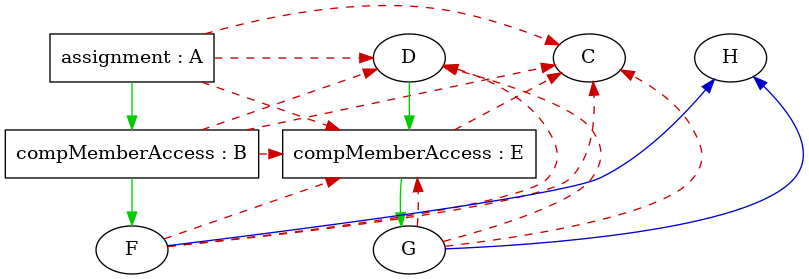

In [28]:
rule = "bug(A) :- ast(A,B), assignment(A), runs_before(A,C), runs_before(A,D), runs_before(A,E), ast(B,F), ast(D,E), ast(E,G), compMemberAccess(B), compMemberAccess(E), runs_before(B,C), runs_before(B,D), runs_before(B,E), runs_before(E,C), ref(F,H), ref(G,H), runs_before(F,C), runs_before(F,D), runs_before(F,E), runs_before(G,C), runs_before(G,D), runs_before(G,E)."
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(rule))

### `ancestor`

Next, we add an equivelant for the `ast` relation, `ancestor`:

In [29]:
header = """
% Settings
:- set(c,5)?
:- set(i,4)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?

:- modeb(20, runs_before(+node, -node))?

runs_before(A,C) :- cfg(A,B), runs_before(B,C).
runs_before(A,C) :- cfg(A,B), cfg(B,C).

:- modeb(20, ancestor(+node, -node))?

ancestor(A,C) :- ast(A,B), ancestor(B,C).
ancestor(A,C) :- ast(A,B), ast(B,C).
"""

script = make_progol_script(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})
with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,5)? - Time taken 0.00s]
[:- set(i,4)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(20,runs_before(+node,-node))? - Time taken 0.00s]
[:- modeb(20,ancestor(+node,-node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_145_f_memmove_01_c_l_30_c_8_).]
[Generalising <bug(bad_232086_id_145_f_memmove_01_c_l_30_c_8_).>]
bug(A) :- writ

bug(A) :- writeToPointer(A), runs_before(A,B), runs_before(A,C), runs_before(A,D), runs_before(A,E), ancestor(A,F), ancestor(A,G), ancestor(A,H), compMemberAccess(D), sizeOf(G), runs_before(D,B), runs_before(E,B), runs_before(E,C), runs_before(F,A), runs_before(F,B), runs_before(F,C), runs_before(F,D), runs_before(F,E), runs_before(F,I), runs_before(F,J), runs_before(G,A), runs_before(G,B), runs_before(G,C), runs_before(G,D), runs_before(G,E), runs_before(G,I), runs_before(H,A), runs_before(H,B), runs_before(H,C), runs_before(H,D), runs_before(H,E), runs_before(H,G), runs_before(H,I), runs_before(H,J), ancestor(C,E), ancestor(C,I), ref(I,K), runs_before(I,B), runs_before(I,C), runs_before(I,D), runs_before(J,B), runs_before(J,C), runs_before(J,D), runs_before(J,E), runs_before(J,I), ancestor(J,F), ref(L,K), ref(M,K), ref(N,K).
[Most-specific clause reduced by 3 literals]
[Most specific clause is]

bug(A) :- writeToPointer(A), runs_before(A,B), runs_before(A,
	C), runs_before(A,D), runs

bug(A) :- writeToPointer(A), runs_before(A,B), runs_before(A,C), runs_before(A,D), runs_before(A,E), ancestor(A,F), ancestor(A,G), ancestor(A,H), compMemberAccess(D), sizeOf(G), runs_before(D,B), runs_before(E,B), runs_before(E,C), runs_before(F,A), runs_before(F,B), runs_before(F,C), runs_before(F,D), runs_before(F,E), runs_before(F,I), runs_before(F,J), runs_before(G,A), runs_before(G,B), runs_before(G,C), runs_before(G,D), runs_before(G,E), runs_before(G,I), runs_before(H,A), runs_before(H,B), runs_before(H,C), runs_before(H,D), runs_before(H,E), runs_before(H,G), runs_before(H,I), runs_before(H,J), ancestor(C,E), ancestor(C,I), ref(I,K), runs_before(I,B), runs_before(I,C), runs_before(I,D), runs_before(J,B), runs_before(J,C), runs_before(J,D), runs_before(J,E), runs_before(J,I), ancestor(J,F), ref(L,K), ref(M,K), ref(N,K).
[Most-specific clause reduced by 3 literals]
[Most specific clause is]

bug(A) :- writeToPointer(A), runs_before(A,B), runs_before(A,
	C), runs_before(A,D), runs

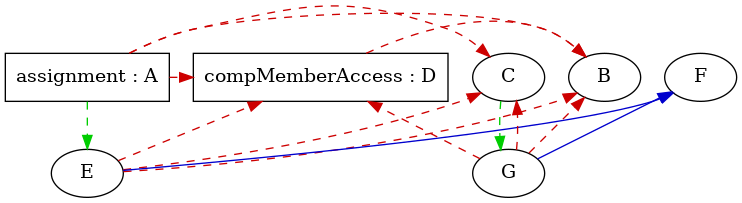

In [30]:
rule = "bug(A) :- assignment(A), runs_before(A,B), runs_before(A,C), runs_before(A,D), ancestor(A,E), ref(E,F), compMemberAccess(D), runs_before(D,B), runs_before(E,B), runs_before(E,C), runs_before(E,D), ancestor(C,G), ref(G,F), runs_before(G,B), runs_before(G,C), runs_before(G,D)."
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(rule))

Rule above shows the system has found related edges, but hasn't found the need to constrain them as much as a human would deem necessary. E.g. there has to be something about B and F that relates them to the bug more than just being references. Potential causes of this issue:

  1. We haven't given the system enough information about the C, B, F nodes for it to extract defining features of them.
  2. We haven't given it a high enough variety of inputs for the rule to need these extra distinguishing features.

It's probably a combination of the two.

### `writeToPointer`

In 

In [31]:
header = """
% Settings
:- set(c,30)?
:- set(i,30)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?

writeToPointer(A) :- ast(A, B), assignment(A), compMemberAccess(B). 
"""

script = make_progol_script(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_145_f_memmove_01_c_l_30_c_8_).]
[Generalising <bug(bad_232086_id_145_f_memmove_01_c_l_30_c_8_).>]
bug(A) :- ast(A,B), ast(A,C), ast(A,D), writeToPointer(A), ast(B,E), ast(B,F), ref(C,G), ref(D,H), ast(E,I), ref(J,G), ref(K,H), ref(L,H), r

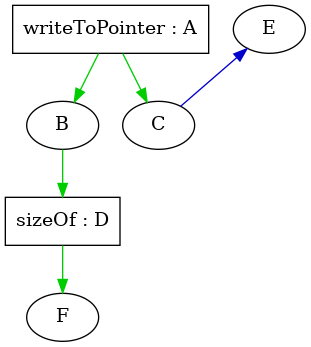

In [32]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C,E), ast(D,F), sizeOf(D)."
))

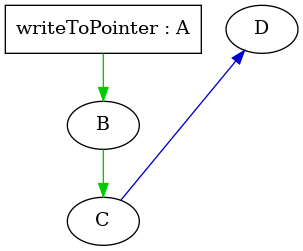

In [33]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- ast(A,B), writeToPointer(A), ast(B,C), ref(C,D)."
))

### `ancestor` and `writeToPointer`

In [34]:
header = """
% Settings
:- set(c,30)?
:- set(i,30)?
:- set(h,500)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?
:- modeb(*, ancestor(+node, -node))?
:- modeb(*, ast(+node, -node))?

ancestor(A,C) :- ast(A,B), ancestor(B,C).
ancestor(A,C) :- ast(A,B), ast(B,C).

writeToPointer(A) :- ast(A, B), assignment(A), compMemberAccess(B). 

"""

script = make_progol_script(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(100,ancestor(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_145_f_memmove_01_c_l_30_c_8_).]
[Generalising <bug(bad_232086_id_145_f_memmove_01_c_l_30_c_8_).>]
bug(A) :- writeToPointer(A), ancestor(A,B), ancestor(A,C), ancestor(A,D), ast(A,E), ast(A,F), ast(A,G), ref(F,H), ref(G,I), sizeOf(C), ancestor(E,B), ast(

bug(A) :- writeToPointer(A), ancestor(A,B), ancestor(A,C), ancestor(A,D), ancestor(A,E), ast(A,F), ast(A,G), ref(B,H), ref(C,I), ref(D,H), ref(E,J), ast(F,B), ast(F,C), ast(G,D), ast(G,E), ref(K,I), ref(L,J), ref(M,J), ref(N,J), ref(O,H), ref(P,H), ref(Q,H).
[Most-specific clause reduced by 17 literals]
[Most specific clause is]

bug(A) :- writeToPointer(A), ancestor(A,B), ast(A,C), ref(B,D),
	ast(C,B).

[C:39,50,10,0 bug(A).]
[C:38,50,10,0 bug(A) :- writeToPointer(A).]
[C:38,50,10,0 bug(A) :- ancestor(A,B).]
[C:38,50,10,0 bug(A) :- ast(A,B).]
[4 explored search nodes]
f=39,p=50,n=10,h=0
[No compression]


[Total time taken 0.077s]


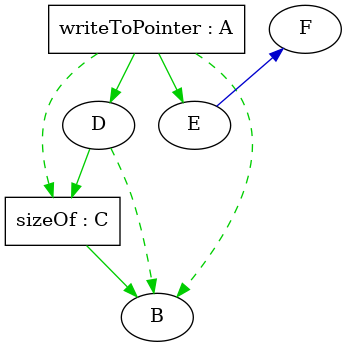

In [35]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- writeToPointer(A), ancestor(A,B), ancestor(A,C), ast(A,D), ast(A,E), ref(E,F), sizeOf(C), ancestor(D,B), ast(C,B), ast(D,C)."
))

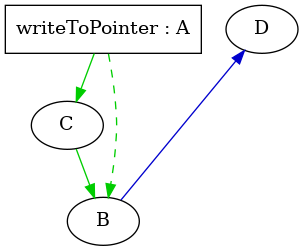

In [36]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- writeToPointer(A), ancestor(A,B), ast(A,C), ref(B,D), ast(C,B)."
))

## *TODO* Tagging the whole tree 

Tag buggy trees as a whole instead of one particular node.
    - Add a tree membership property to each node.
    - Add tree_id as extra parameter.

In [37]:
node_and_tree = []
for node in nodes:
    start, end = node.split('_id')
    node_and_tree.append('(' +start+ ', ' +node+ ')')

node_and_tree[0:5]

['(good_62865, good_62865_id_51_f_l_c_)',
 '(good_62916, good_62916_id_180_f_l_22_c_)',
 '(bad_62867, bad_62867_id_91_f_memcpy_16_c_l_52_c_12_)',
 '(good_62804, good_62804_id_74_f_l_c_)',
 '(good_62913, good_62913_id_15_f_l_c_)']

In [38]:
node_tree_types = [
    'node'+ node_tree +'.' for node_tree in node_and_tree
]

tree_positive_examples = [
    'bug('+node_id+').' for node_id in bad_node
]

tree_negative_examples = [
    ':- bug('+node_id+').' for node_id in good_node
]

In [39]:
def extract_tree_ids(tree):
    line = tree.split('\n')[2]
    line = line.strip()
    line = line.split('(')[1]
    tree_id = line.split('_id')[0]

    return tree_id

In [40]:
tree_ids = []
for tree in prolog.tree:
    tree_ids.append(extract_tree_ids(tree))

In [41]:
trees = [
    'tree('+ tree_label +').' for tree_label in tree_ids
]

In [42]:
def make_progol_script_tag_whole_tree(header, testcases):
    script_template = """
{header}

%%Trees
{trees}

%% Types
{types}

%% background knowledge
{bg_knowledge}

%% learning task
%% positive examples
{positive_examples}

%% negative examples
{negative_examples}

    """
    script = script_template.format(
        header = header,
        trees =  '\n'.join(trees),
        types = '\n'.join(node_tree_types),
        bg_knowledge = '\n'.join(prolog['tree']),
        positive_examples='\n'.join(tree_positive_examples),
        negative_examples='\n'.join(tree_negative_examples),
    )
    
    # remove all lines not related to this testcase
    script = '\n'.join([
        line for line in script.split("\n")  if any(
            str(testcase) in line for testcase in testcases
        ) or not ("good_" in line or "bad_" in line)
    ])
    
    return script

In [43]:
header = """
% Settings
:- set(c,30)?
:- set(i,30)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
% :- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?
"""

script = make_progol_script_tag_whole_tree(header, {62804, 62852, 62869, 232012, 62900})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232012_id_146_f_memcpy_01_c_l_30_c_8_).]
[Generalising <bug(bad_232012_id_146_f_memcpy_01_c_l_30_c_8_).>]
bug(A) :- ast(A,B), ast(A,C), ast(A,D), writeToPointer(A), ast(B,E), ast(B,F),

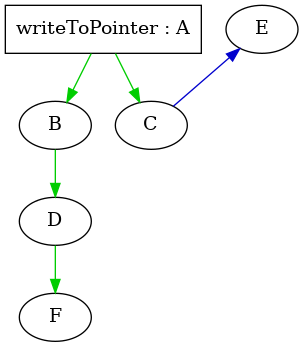

In [45]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot("""bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C,
	E), ast(D,F)."""))

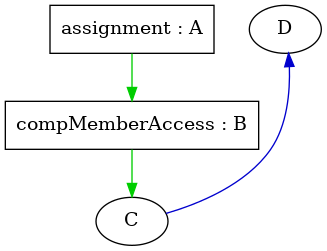

In [44]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot("""bug(A) :- ast(A,B), assignment(A), ast(B,C), compMemberAccess(B),
	ref(C,D)."""))

## *TODO* Try detect a simpler bug 

Try to detect a simpler bug first: "was there any memory allocated to this pointer in the first place?".

## *TODO* Add properties to _positively_ describe the buggy behaviour

First, tell Progol that it is allowed to use the fact that a node _isn't_ a call to `sizeof`:

```
:- modeb(*, not(sizeOf(+node)))?
```

In [28]:
header = """
% Settings
:- set(c,10)?
:- set(i,10)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,1500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, sizeOf(+node))?
:- modeb(1, not(sizeOf(+node)))?

:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?
:- modeb(10, ancestor(+node, -node))?
:- modeb(10, runs_before(+node, -node))?

writeToPointer(A) :- ast(A, B), assignment(A), compMemberAccess(B). 

ancestor(A,C) :- ast(A,B), ancestor(B,C).
ancestor(A,C) :- ast(A,B), ast(B,C).

runs_before(A,C) :- cfg(A,B), runs_before(B,C).
runs_before(A,C) :- cfg(A,B), cfg(B,C).
"""

script = make_progol_script(header, {
    62852,
    62900,
    62869,
    62804,
    232012,
    62853,
    62917,
    232086,
    62901,
    62854,
    62867,
    62902,
    62915,
    62868,
    62861,
    62916,
    62909,
    62865,
    62913,
    62821,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,10)? - Time taken 0.00s]
[:- set(i,10)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,1500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(1,not(sizeOf(+node)))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(10,ancestor(+node,-node))? - Time taken 0.00s]
[:- modeb(10,runs_before(+node,-node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).]
[Generalising <bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).>]
bug(A) :- not(sizeOf(A

bug(A) :- not(sizeOf(A)), writeToPointer(A), ancestor(A,B), ancestor(A,C), ancestor(A,D), runs_before(A,E), runs_before(A,F), runs_before(A,G), runs_before(A,H), not(sizeOf(B)), not(sizeOf(D)), not(sizeOf(E)), not(sizeOf(F)), not(sizeOf(G)), not(sizeOf(H)), sizeOf(C), ancestor(F,H), ancestor(F,I), runs_before(B,A), runs_before(B,E), runs_before(B,F), runs_before(B,G), runs_before(B,H), runs_before(B,I), runs_before(B,J), runs_before(C,A), runs_before(C,E), runs_before(C,F), runs_before(C,G), runs_before(C,H), runs_before(C,I), runs_before(D,A), runs_before(D,C), runs_before(D,E), runs_before(D,F), runs_before(D,G), runs_before(D,H), runs_before(D,I), runs_before(D,J), runs_before(G,E), runs_before(H,E), runs_before(H,F), not(sizeOf(I)), not(sizeOf(J)), ref(I,K), ancestor(J,B), runs_before(I,E), runs_before(I,F), runs_before(I,G), runs_before(J,E), runs_before(J,F), runs_before(J,G), runs_before(J,H), runs_before(J,I), not(sizeOf(K)), ref(L,K), ref(M,K), ref(N,K), not(sizeOf(L)), not(si

bug(A) :- not(sizeOf(A)), writeToPointer(A), ancestor(A,B), ancestor(A,C), ancestor(A,D), runs_before(A,E), runs_before(A,F), runs_before(A,G), runs_before(A,H), not(sizeOf(B)), not(sizeOf(D)), not(sizeOf(E)), not(sizeOf(F)), not(sizeOf(G)), not(sizeOf(H)), sizeOf(C), ancestor(F,H), ancestor(F,I), runs_before(B,A), runs_before(B,E), runs_before(B,F), runs_before(B,G), runs_before(B,H), runs_before(B,I), runs_before(B,J), runs_before(C,A), runs_before(C,E), runs_before(C,F), runs_before(C,G), runs_before(C,H), runs_before(C,I), runs_before(D,A), runs_before(D,C), runs_before(D,E), runs_before(D,F), runs_before(D,G), runs_before(D,H), runs_before(D,I), runs_before(D,J), runs_before(G,E), runs_before(H,E), runs_before(H,F), not(sizeOf(I)), not(sizeOf(J)), ref(I,K), ancestor(J,B), runs_before(I,E), runs_before(I,F), runs_before(I,G), runs_before(J,E), runs_before(J,F), runs_before(J,G), runs_before(J,H), runs_before(J,I), not(sizeOf(K)), ref(L,K), ref(M,K), ref(N,K), not(sizeOf(L)), not(si

bug(A) :- not(sizeOf(A)), writeToPointer(A), ancestor(A,B), ancestor(A,C), ancestor(A,D), runs_before(A,E), runs_before(A,F), runs_before(A,G), runs_before(A,H), not(sizeOf(B)), not(sizeOf(D)), not(sizeOf(E)), not(sizeOf(F)), not(sizeOf(G)), not(sizeOf(H)), sizeOf(C), ancestor(F,H), ancestor(F,I), runs_before(B,A), runs_before(B,E), runs_before(B,F), runs_before(B,G), runs_before(B,H), runs_before(B,I), runs_before(B,J), runs_before(C,A), runs_before(C,E), runs_before(C,F), runs_before(C,G), runs_before(C,H), runs_before(C,I), runs_before(D,A), runs_before(D,C), runs_before(D,E), runs_before(D,F), runs_before(D,G), runs_before(D,H), runs_before(D,I), runs_before(D,J), runs_before(G,E), runs_before(H,E), runs_before(H,F), not(sizeOf(I)), not(sizeOf(J)), ref(I,K), ancestor(J,B), runs_before(I,E), runs_before(I,F), runs_before(I,G), runs_before(J,E), runs_before(J,F), runs_before(J,G), runs_before(J,H), runs_before(J,I), not(sizeOf(K)), ref(L,K), ref(M,K), ref(N,K), not(sizeOf(L)), not(si

bug(A) :- not(sizeOf(A)), writeToPointer(A), ancestor(A,B), ancestor(A,C), ancestor(A,D), runs_before(A,E), runs_before(A,F), runs_before(A,G), runs_before(A,H), not(sizeOf(B)), not(sizeOf(D)), not(sizeOf(E)), not(sizeOf(F)), not(sizeOf(G)), not(sizeOf(H)), sizeOf(C), ancestor(F,H), ancestor(F,I), runs_before(B,A), runs_before(B,E), runs_before(B,F), runs_before(B,G), runs_before(B,H), runs_before(B,I), runs_before(B,J), runs_before(C,A), runs_before(C,E), runs_before(C,F), runs_before(C,G), runs_before(C,H), runs_before(C,I), runs_before(D,A), runs_before(D,C), runs_before(D,E), runs_before(D,F), runs_before(D,G), runs_before(D,H), runs_before(D,I), runs_before(D,J), runs_before(G,E), runs_before(H,E), runs_before(H,F), not(sizeOf(I)), not(sizeOf(J)), ref(I,K), ancestor(J,B), runs_before(I,E), runs_before(I,F), runs_before(I,G), runs_before(J,E), runs_before(J,F), runs_before(J,G), runs_before(J,H), runs_before(J,I), not(sizeOf(K)), ref(L,K), ref(M,K), ref(N,K), not(sizeOf(L)), not(si

bug(A) :- not(sizeOf(A)), writeToPointer(A), ancestor(A,B), ancestor(A,C), ancestor(A,D), runs_before(A,E), runs_before(A,F), runs_before(A,G), runs_before(A,H), not(sizeOf(B)), not(sizeOf(D)), not(sizeOf(E)), not(sizeOf(F)), not(sizeOf(G)), not(sizeOf(H)), sizeOf(C), ancestor(F,H), ancestor(F,I), runs_before(B,A), runs_before(B,E), runs_before(B,F), runs_before(B,G), runs_before(B,H), runs_before(B,I), runs_before(B,J), runs_before(C,A), runs_before(C,E), runs_before(C,F), runs_before(C,G), runs_before(C,H), runs_before(C,I), runs_before(D,A), runs_before(D,C), runs_before(D,E), runs_before(D,F), runs_before(D,G), runs_before(D,H), runs_before(D,I), runs_before(D,J), runs_before(G,E), runs_before(H,E), runs_before(H,F), not(sizeOf(I)), not(sizeOf(J)), ref(I,K), ancestor(J,B), runs_before(I,E), runs_before(I,F), runs_before(I,G), runs_before(J,E), runs_before(J,F), runs_before(J,G), runs_before(J,H), runs_before(J,I), not(sizeOf(K)), ref(L,K), ref(M,K), ref(N,K), not(sizeOf(L)), not(si

bug(A) :- not(sizeOf(A)), writeToPointer(A), ancestor(A,B), ancestor(A,C), ancestor(A,D), runs_before(A,E), runs_before(A,F), runs_before(A,G), runs_before(A,H), not(sizeOf(B)), not(sizeOf(D)), not(sizeOf(E)), not(sizeOf(F)), not(sizeOf(G)), not(sizeOf(H)), sizeOf(C), ancestor(F,H), ancestor(F,I), runs_before(B,A), runs_before(B,E), runs_before(B,F), runs_before(B,G), runs_before(B,H), runs_before(B,I), runs_before(B,J), runs_before(C,A), runs_before(C,E), runs_before(C,F), runs_before(C,G), runs_before(C,H), runs_before(C,I), runs_before(D,A), runs_before(D,C), runs_before(D,E), runs_before(D,F), runs_before(D,G), runs_before(D,H), runs_before(D,I), runs_before(D,J), runs_before(G,E), runs_before(H,E), runs_before(H,F), not(sizeOf(I)), not(sizeOf(J)), ref(I,K), ancestor(J,B), runs_before(I,E), runs_before(I,F), runs_before(I,G), runs_before(J,E), runs_before(J,F), runs_before(J,G), runs_before(J,H), runs_before(J,I), not(sizeOf(K)), ref(L,K), ref(M,K), ref(N,K), not(sizeOf(L)), not(si

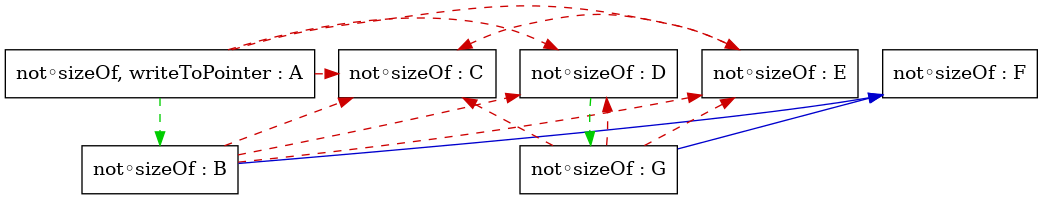

In [29]:
rule = """bug(A) :- not(sizeOf(A)), writeToPointer(A), ancestor(A,B), runs_before(A,
	C), runs_before(A,D), runs_before(A,E), not(sizeOf(B)),
	not(sizeOf(C)), not(sizeOf(D)), not(sizeOf(E)), ref(B,
	F), ancestor(D,G), runs_before(B,C), runs_before(B,D),
	runs_before(B,E), runs_before(E,C), not(sizeOf(F)), 
	not(sizeOf(G)), ref(G,F), runs_before(G,C), runs_before(G,
	D), runs_before(G,E)."""

graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(rule))

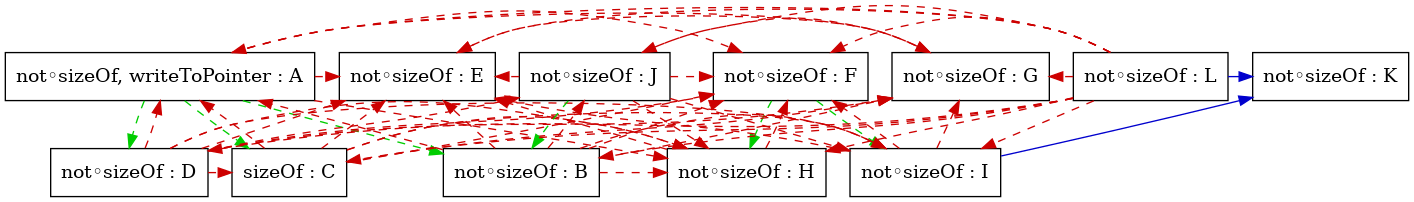

In [30]:
rule = """bug(A) :- not(sizeOf(A)), writeToPointer(A), ancestor(A,B), ancestor(A,
	C), ancestor(A,D), runs_before(A,E), runs_before(A,F),
	runs_before(A,G), runs_before(A,H), not(sizeOf(B)), 
	not(sizeOf(D)), not(sizeOf(E)), not(sizeOf(F)), not(sizeOf(G)),
	not(sizeOf(H)), sizeOf(C), ancestor(F,H), ancestor(F,
	I), runs_before(B,A), runs_before(B,E), runs_before(B,
	F), runs_before(B,G), runs_before(B,H), runs_before(B,
	I), runs_before(B,J), runs_before(C,A), runs_before(C,
	E), runs_before(C,F), runs_before(C,G), runs_before(C,
	H), runs_before(C,I), runs_before(D,A), runs_before(D,
	C), runs_before(D,E), runs_before(D,F), runs_before(D,
	G), runs_before(D,H), runs_before(D,I), runs_before(D,
	J), runs_before(G,E), runs_before(H,E), runs_before(H,
	F), not(sizeOf(I)), not(sizeOf(J)), ref(I,K), ancestor(J,
	B), runs_before(I,E), runs_before(I,F), runs_before(I,
	G), runs_before(J,E), runs_before(J,F), runs_before(J,
	G), runs_before(J,H), runs_before(J,I), not(sizeOf(K)),
	ref(L,K), not(sizeOf(L)), runs_before(L,A), runs_before(L,
	B), runs_before(L,C), runs_before(L,D), runs_before(L,
	E), runs_before(L,F), runs_before(L,G), runs_before(L,
	H), runs_before(L,I), runs_before(L,J)."""

graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(rule))

Maybe it uses this not a bit too keenly... Can we make tell it to use it only in a specific context? Try this by adding the following background knowledge and mode declaration:

```
:- modeb(*, alloc_doesnt_check_sizeOf(+node))?

checks_sizeOf(A) :- ancestor(A, B), sizeof(B).
alloc_doesnt_check_sizeOf(A) :- alloc(A), not(checks_sizeOf(A)).
```

It ended up just not making use of this :( Why?

#### Idea?

One problem we seem to have in general is that if we give the system too much flexibility in navigating the graph, the generalisation step becomes computationnally infeasible. So far, most of our results have been from only allowing navigation through the `cfg` nd `ast` edges in _one direction_. This poses a problem for finding a pattern which matches our bug. 

For example, in some of the rules above, we often end up with structures like:


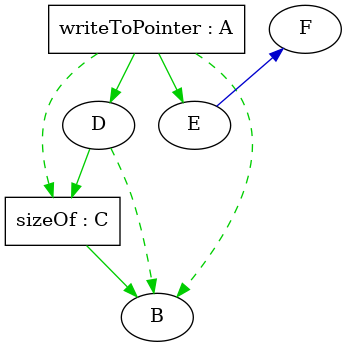

In [33]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- writeToPointer(A), ancestor(A,B), ancestor(A,C), ast(A,D), ast(A,E), ref(E,F), sizeOf(C), ancestor(D,B), ast(C,B), ast(D,C)."
))

But it's possible that the system needs to be able to walk up the tree from `F` to find the distingishing part of the code: the malloc call. I.e. we want the rule to look like a bit like this:

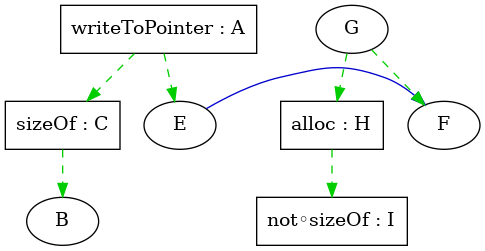

In [34]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot("""
bug(A) :- writeToPointer(A), ancestor(A,C), ancestor(A,E), ref(E,F), sizeOf(C), ancestor(C,B), 
	ancestor(G,F), ancestor(G,H), alloc(H), ancestor(H,I), not(sizeOf(I)).
"""))

Importantly, the system needs to be free to to generate the `ancestor(G,F)` edge. This requires allowing the following in the rule body:
```
:- modeb(10, ancestor(+node, -node))?
:- modeb(10, ancestor(-node, +node))?
```

However, as soon as you allow the system to walk up and down the tree, the search space increases massively. This idea does run, but it requires us to also set the following limits:
```
:- set(c,3)?
:- set(i,3)?
```

which massively limit Progols ability to search. So it doesn't find the distinguishing features anyway:

In [35]:
header = """
% Settings
:- set(c,3)?
:- set(i,3)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,1500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, sizeOf(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?
:- modeb(*, alloc_doesnt_check_sizeOf(+node))?
:- modeb(10, ast(+node, -node))?
:- modeb(10, ast(-node, +node))?
%:- modeb(10, runs_before(+node, -node))?

writeToPointer(A) :- ast(A, B), assignment(A), compMemberAccess(B). 

checks_sizeOf(A) :- ancestor(A, B), sizeof(B).
alloc_doesnt_check_sizeOf(A) :- alloc(A), not(checks_sizeOf(A)).

% ancestor(A,C) :- ast(A,B), ancestor(B,C).
% ancestor(A,C) :- ast(A,B), ast(B,C).

runs_before(A,C) :- cfg(A,B), runs_before(B,C).
runs_before(A,C) :- cfg(A,B), cfg(B,C).
"""

script = make_progol_script(header, {
    62852, 62900, 62869, 62804, 232012, 62853, 62917, 232086, 62901, 62854, 62867, 62902, 62915, 62868, 62861, 62916, 62909, 62865, 62913, 62821
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,3)? - Time taken 0.00s]
[:- set(i,3)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,1500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(100,alloc_doesnt_check_sizeOf(+node))? - Time taken 0.00s]
[:- modeb(10,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(10,ast(-node,+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).]
[Generalising <bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).>]
bug(A) :- writeToPointer(A), ast(A,B), ast(A,C), ast(A,D), ast(E,A), re

bug(A) :- writeToPointer(A), ast(A,B), ast(A,C), ast(A,D), ast(E,A), ref(C,F), ref(D,G), ast(B,H), ast(B,I), ast(E,F), ast(E,J), ast(E,K), ast(L,E), ref(M,F), ref(N,G), ref(O,G), ref(P,G), sizeOf(H), ast(J,Q), ast(K,M), ast(H,R), ast(L,G), ast(L,S), ast(L,T), ast(U,L).
[Most-specific clause reduced by 11 literals]
[Most specific clause is]

bug(A) :- writeToPointer(A), ast(A,B), ast(A,C), ast(A,D), ast(E,
	A), ref(C,F), ref(D,G), ast(B,H), ast(E,F), ast(I,E),
	sizeOf(H), ast(H,J), ast(I,G), ast(K,I).

[C:279,300,20,0 bug(A).]
[C:278,300,20,0 bug(A) :- writeToPointer(A).]
[C:278,300,20,0 bug(A) :- ast(A,B).]
[C:278,300,20,0 bug(A) :- ast(A,B).]
[C:278,300,20,0 bug(A) :- ast(A,B).]
[C:278,300,20,0 bug(A) :- ast(B,A).]
[6 explored search nodes]
f=279,p=300,n=20,h=0
[No compression]

[Generalising bug(bad_62900_id_121_f_memmove_01_c_l_29_c_8_).]
[Generalising <bug(bad_62900_id_121_f_memmove_01_c_l_29_c_8_).>]
bug(A) :- writeToPointer(A), ast(A,B), ast(A,C), ast(A,D), ast(E,A), ref(C,F), re

bug(A) :- writeToPointer(A), ast(A,B), ast(A,C), ast(A,D), ast(E,A), ref(C,F), ref(D,G), ast(B,H), ast(B,I), ast(E,F), ast(E,J), ast(E,K), ast(L,E), ref(M,F), ref(N,G), ref(O,G), ref(P,G), sizeOf(H), ast(H,Q), ast(J,R), ast(K,M), ast(L,G), ast(L,S), ast(L,T), ast(U,L).
[Most-specific clause reduced by 11 literals]
[Most specific clause is]

bug(A) :- writeToPointer(A), ast(A,B), ast(A,C), ast(A,D), ast(E,
	A), ref(C,F), ref(D,G), ast(B,H), ast(E,F), ast(I,E),
	sizeOf(H), ast(H,J), ast(I,G), ast(K,I).

[C:279,300,20,0 bug(A).]
[C:278,300,20,0 bug(A) :- writeToPointer(A).]
[C:278,300,20,0 bug(A) :- ast(A,B).]
[C:278,300,20,0 bug(A) :- ast(A,B).]
[C:278,300,20,0 bug(A) :- ast(A,B).]
[C:278,300,20,0 bug(A) :- ast(B,A).]
[6 explored search nodes]
f=279,p=300,n=20,h=0
[No compression]

[Generalising bug(bad_62821_id_110_f_loop_18_c_l_34_c_12_).]
[Generalising <bug(bad_62821_id_110_f_loop_18_c_l_34_c_12_).>]
bug(A) :- writeToPointer(A), ast(A,B), ast(A,C), ast(D,A), ast(B,E), ast(B,F), ast(C,

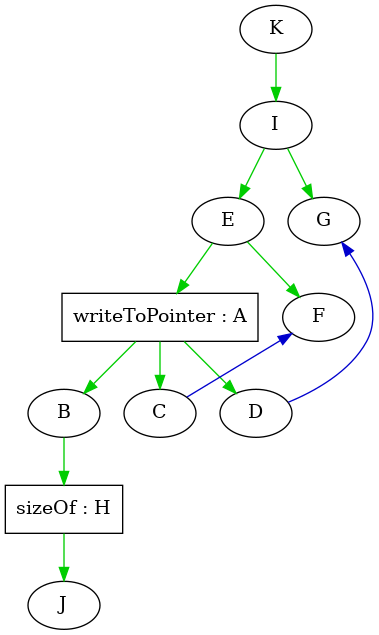

In [36]:
rule = """bug(A) :- writeToPointer(A), ast(A,B), ast(A,C), ast(A,D), ast(E,
	A), ref(C,F), ref(D,G), ast(B,H), ast(E,F), ast(I,E),
	sizeOf(H), ast(H,J), ast(I,G), ast(K,I)."""
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(rule))

One potential solve for this is to declare the bug as the root node of each tree (or tagging the tree as a whole as bug, ala the suggestion in the meeting). If you start at the root of the tree, you don't need to allow walking back up it (though we limit the shape of our ast edges to a real tree, so that `A` and `G` would have to share a common `ancestor`). 

Lets try this now:

In [79]:
def find_root_node(tree, nodes):
    """
    Given a <tree_id> e.g. bad_62804 and the list of all node ids, <nodes>, return the root node of the 
    """
    tree_nodes = [node for node in nodes if tree in node]
    
    # root node of each tree seems to be the one with the largest id
    max_id = 0
    root_node = None
    
    for node in tree_nodes:
        node_id = int(node.split("_")[3])
        if node_id >= max_id:
            max_id = node_id
            root_node = node
            
    return root_node

In [81]:
root_nodes = [find_root_node(tree, nodes) for tree in tree_ids]
root_nodes[0:5]

['bad_232086_id_185_f_l_c_',
 'bad_232012_id_185_f_l_c_',
 'bad_62917_id_151_f_l_c_',
 'bad_62916_id_174_f_l_c_',
 'bad_62915_id_153_f_l_c_']

In [82]:
root_positive_examples = [
    "bug(" + node + ").\n" for node in root_nodes if 'bad' in node
]
root_negative_examples = [
    ":- bug("+ node + ").\n" for node in root_nodes if 'good' in node
]

In [95]:
header = """
% Settings
:- set(c,3)?
:- set(i,3)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,1500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, sizeOf(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?
:- modeb(*, alloc_doesnt_check_sizeOf(+node))?
:- modeb(*, ancestor(+node, -node))?
:- modeb(*, runs_before(+node, -node))?

writeToPointer(A) :- ast(A, B), assignment(A), compMemberAccess(B). 

contains_sizeOf_call(A) :- ancestor(A, B), sizeof(B).
alloc_doesnt_check_sizeOf(A) :- alloc(A), not(contains_sizeOf_call(A)).

ancestor(A,C) :- ast(A,B), ancestor(B,C).
ancestor(A,C) :- ast(A,B), ast(B,C).

runs_before(A,C) :- cfg(A,B), runs_before(B,C).
runs_before(A,C) :- cfg(A,B), cfg(B,C).
"""

testcases = {
    62852, 62900, 62869, 62804, 232012, 62853, 62917, 232086, 62901, 62854, 62867, 62902, 62915, 62868, 62861, 62916, 62909, 62865, 62913, 62821
}

script = make_progol_script(
    header,
    testcases,
    types=types,
    positive_examples=root_positive_examples,
    negative_examples=root_negative_examples,
)

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,3)? - Time taken 0.00s]
[:- set(i,3)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,1500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(100,alloc_doesnt_check_sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,ancestor(+node,-node))? - Time taken 0.00s]
[:- modeb(100,runs_before(+node,-node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_185_f_l_c_).]
[Generalising <bug(bad_232086_id_185_f_l_c_).>]
bug(A) :- ref(A,B), ancestor(A,C), ancestor(A,D), ancestor(A,E), ancestor(A,F), ancestor(A,G

bug(A) :- ref(A,B), ancestor(A,C), ancestor(A,D), ancestor(A,E), ancestor(A,F), ancestor(A,G), ancestor(A,H), ancestor(A,I), ancestor(A,J), ancestor(A,K), ancestor(A,L), ancestor(A,M), ancestor(A,N), ancestor(A,O), ancestor(A,P), ancestor(A,Q), ancestor(A,R), ancestor(A,S), ancestor(A,T), ancestor(A,U), ancestor(A,V), ancestor(A,W), ancestor(A,X), ancestor(A,Y), ancestor(A,Z), ancestor(A,A0), ancestor(A,B0), ancestor(A,C0), ancestor(A,D0), ancestor(A,E0), ancestor(A,F0), ancestor(A,G0), ancestor(A,H0), ancestor(A,I0), ancestor(A,J0), ancestor(A,K0), ancestor(A,L0), ancestor(A,M0), ancestor(A,N0), ancestor(A,O0), ancestor(A,P0), ancestor(A,Q0), ancestor(A,R0), ancestor(A,S0), ancestor(A,T0), ancestor(A,U0), ancestor(A,V0), ancestor(A,W0), ancestor(A,X0), ancestor(A,Y0), ancestor(A,Z0), ancestor(A,A1), ancestor(A,B1), ancestor(A,C1), ancestor(A,D1), ancestor(A,E1), ancestor(A,F1), ref(G1,B), ancestor(G1,H1), ancestor(G1,I1), ancestor(G1,J1), ancestor(G1,K1), ancestor(G1,L1), ancestor(G1,

bug(A) :- ref(A,B), ancestor(A,C), ancestor(A,D), ancestor(A,E), ancestor(A,F), ancestor(A,G), ancestor(A,H), ancestor(A,I), ancestor(A,J), ancestor(A,K), ancestor(A,L), ancestor(A,M), ancestor(A,N), ancestor(A,O), ancestor(A,P), ancestor(A,Q), ancestor(A,R), ancestor(A,S), ancestor(A,T), ancestor(A,U), ancestor(A,V), ancestor(A,W), ancestor(A,X), ancestor(A,Y), ancestor(A,Z), ancestor(A,A0), ancestor(A,B0), ancestor(A,C0), ancestor(A,D0), ancestor(A,E0), ancestor(A,F0), ancestor(A,G0), ancestor(A,H0), ancestor(A,I0), ancestor(A,J0), ancestor(A,K0), ancestor(A,L0), ancestor(A,M0), ancestor(A,N0), ancestor(A,O0), ancestor(A,P0), ancestor(A,Q0), ancestor(A,R0), ancestor(A,S0), ancestor(A,T0), ancestor(A,U0), ancestor(A,V0), ancestor(A,W0), ancestor(A,X0), ancestor(A,Y0), ancestor(A,Z0), ancestor(A,A1), ancestor(A,B1), ancestor(A,C1), ancestor(A,D1), ancestor(A,E1), ancestor(A,F1), ref(G1,B), ancestor(G1,H1), ancestor(G1,I1), ancestor(G1,J1), ancestor(G1,K1), ancestor(G1,L1), ancestor(G1,

[C:278,300,20,0 bug(A) :- ancestor(A,B).]
[3 explored search nodes]
f=279,p=300,n=20,h=0
[No compression]

[Generalising bug(bad_62861_id_152_f_l_c_).]
[Generalising <bug(bad_62861_id_152_f_l_c_).>]
bug(A) :- ref(A,B), ancestor(A,C), ancestor(A,D), ancestor(A,E), ancestor(A,F), ancestor(A,G), ancestor(A,H), ancestor(A,I), ancestor(A,J), ancestor(A,K), ancestor(A,L), ancestor(A,M), ancestor(A,N), ancestor(A,O), ancestor(A,P), ancestor(A,Q), ancestor(A,R), ancestor(A,S), ancestor(A,T), ancestor(A,U), ancestor(A,V), ancestor(A,W), ancestor(A,X), ancestor(A,Y), ancestor(A,Z), ancestor(A,A0), ancestor(A,B0), ancestor(A,C0), ancestor(A,D0), ancestor(A,E0), ancestor(A,F0), ancestor(A,G0), ancestor(A,H0), ancestor(A,I0), ancestor(A,J0), ancestor(A,K0), ancestor(A,L0), ancestor(A,M0), ancestor(A,N0), ancestor(A,O0), ancestor(A,P0), ancestor(A,Q0), ancestor(A,R0), ancestor(A,S0), ancestor(A,T0), ancestor(A,U0), ancestor(A,V0), ancestor(A,W0), ancestor(A,X0), ancestor(A,Y0), ancestor(A,Z0), ances

bug(A) :- ref(A,B), ancestor(A,C), ancestor(A,D), ancestor(A,E), ancestor(A,F), ancestor(A,G), ancestor(A,H), ancestor(A,I), ancestor(A,J), ancestor(A,K), ancestor(A,L), ancestor(A,M), ancestor(A,N), ancestor(A,O), ancestor(A,P), ancestor(A,Q), ancestor(A,R), ancestor(A,S), ancestor(A,T), ancestor(A,U), ancestor(A,V), ancestor(A,W), ancestor(A,X), ancestor(A,Y), ancestor(A,Z), ancestor(A,A0), ancestor(A,B0), ancestor(A,C0), ancestor(A,D0), ancestor(A,E0), ancestor(A,F0), ancestor(A,G0), ancestor(A,H0), ancestor(A,I0), ancestor(A,J0), ancestor(A,K0), ancestor(A,L0), ancestor(A,M0), ancestor(A,N0), ancestor(A,O0), ancestor(A,P0), ancestor(A,Q0), ancestor(A,R0), ancestor(A,S0), ancestor(A,T0), ancestor(A,U0), ancestor(A,V0), ancestor(A,W0), ancestor(A,X0), ref(Y0,B), ancestor(Y0,Z0), ancestor(Y0,A1), ancestor(Y0,B1), ancestor(Y0,C1), ancestor(Y0,D1), ancestor(Y0,E1), ancestor(Y0,F1), ancestor(Y0,G1), ancestor(Y0,H1), ancestor(Y0,I1), ancestor(Y0,J1), ancestor(Y0,K1), ancestor(Y0,L1), ance

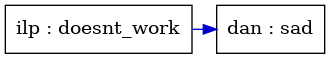

In [94]:
rule = """bug(A) :- ilp(doesnt_work), ref(doesnt_work,sad), dan(sad)."""
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(rule))



Use our own, or Claires, rule and tailor our background knowledge to provide it.